# MCMC Introduction

by Jason Wang and Henry Ngo (2018)

Here, we will explain how to sample an orbit posterior using MCMC techniques. MCMC samplers take some time
to fully converge on the complex posterior, but should be able to explore all posteriors in roughly the same
amount of time (unlike OFTI). We will use the parallel-tempered version of the Affine-invariant sample from
the `emcee` package, as the parallel tempering helps the walkers get out of local minima. Parallel-tempering can
be disabled by setting the number of temperatures to 1, and will revert back to using the regular ensemble 
sampler from emcee. 

## Read in Data and Set up Sampler

We use `orbitize.driver.Driver` to streamline the processes of reading in data, setting up the two-body interaction, and setting up the MCMC sampler.

When setting up the sampler, we need to decide how many temperatures and how many walkers per temperature
to use. Increasing the number of temperatures further ensures your walkers will explore all of parameter space
and will not get stuck in local minima. Increasing the number of walkers gives you more samples to use, and, for
the Affine-invariant sampler, a minimum number is required for good convergence. Of course, the tradeoff is that
more samplers means more computation time. We find 20 temperatures and 1000 walkers to be reliable for convergence. Since this is a tutorial meant to be run quickly, we use fewer walkers and temperatures here.

Note that we will only use the samples from the lowest-temperature walkers. We also assume that our astrometric measurements follow a Gaussian distribution.

`orbitize` can also fit for the total mass of the system and system parallax, including marginalizing over the uncertainties in those parameters.

In [1]:
import numpy as np

import orbitize
from orbitize import driver
import multiprocessing as mp

filename = "{}/GJ504.csv".format(orbitize.DATADIR)

# system parameters
num_secondary_bodies = 1
system_mass = 1.75 # [Msol]
plx = 51.44 # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.12 # [mas]

# MCMC parameters
num_temps = 5
num_walkers = 30
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

## Running the MCMC Sampler

We need to pick how many steps the MCMC sampler should sample. Additionally, because the samples are correlated,
we often only save every nth sample. This helps when we run a lot of samples, because saving all the samples requires
too much disk space and many samples are unnecessary because they are correlated.

In [3]:
total_orbits = 10000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 10 # steps to burn in per walker
thin = 2 # only save every 2nd step

my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/orbitize/priors.py:269: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/orbitize/priors.py:269: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/orbitize/priors.py:269: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/orbitize/priors.py:269: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/orbitize/priors.py:163: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((eleme

Burn in complete
Run complete


After completing the samples, the `'run_sampler'` method also creates a `'Results'` object that can be accessed
with `'my_sampler.results'`.

## Plotting Basics

We will make some basic plots to visualize the samples in `'my_sampler.results'`. Orbitize currently has two basic
plotting functions which returns matplotlib Figure objects. First, we can make a corner plot (also known as
triangle plot, scatterplot matrix, or pairs plot) to visualize correlations between pairs of orbit parameters:

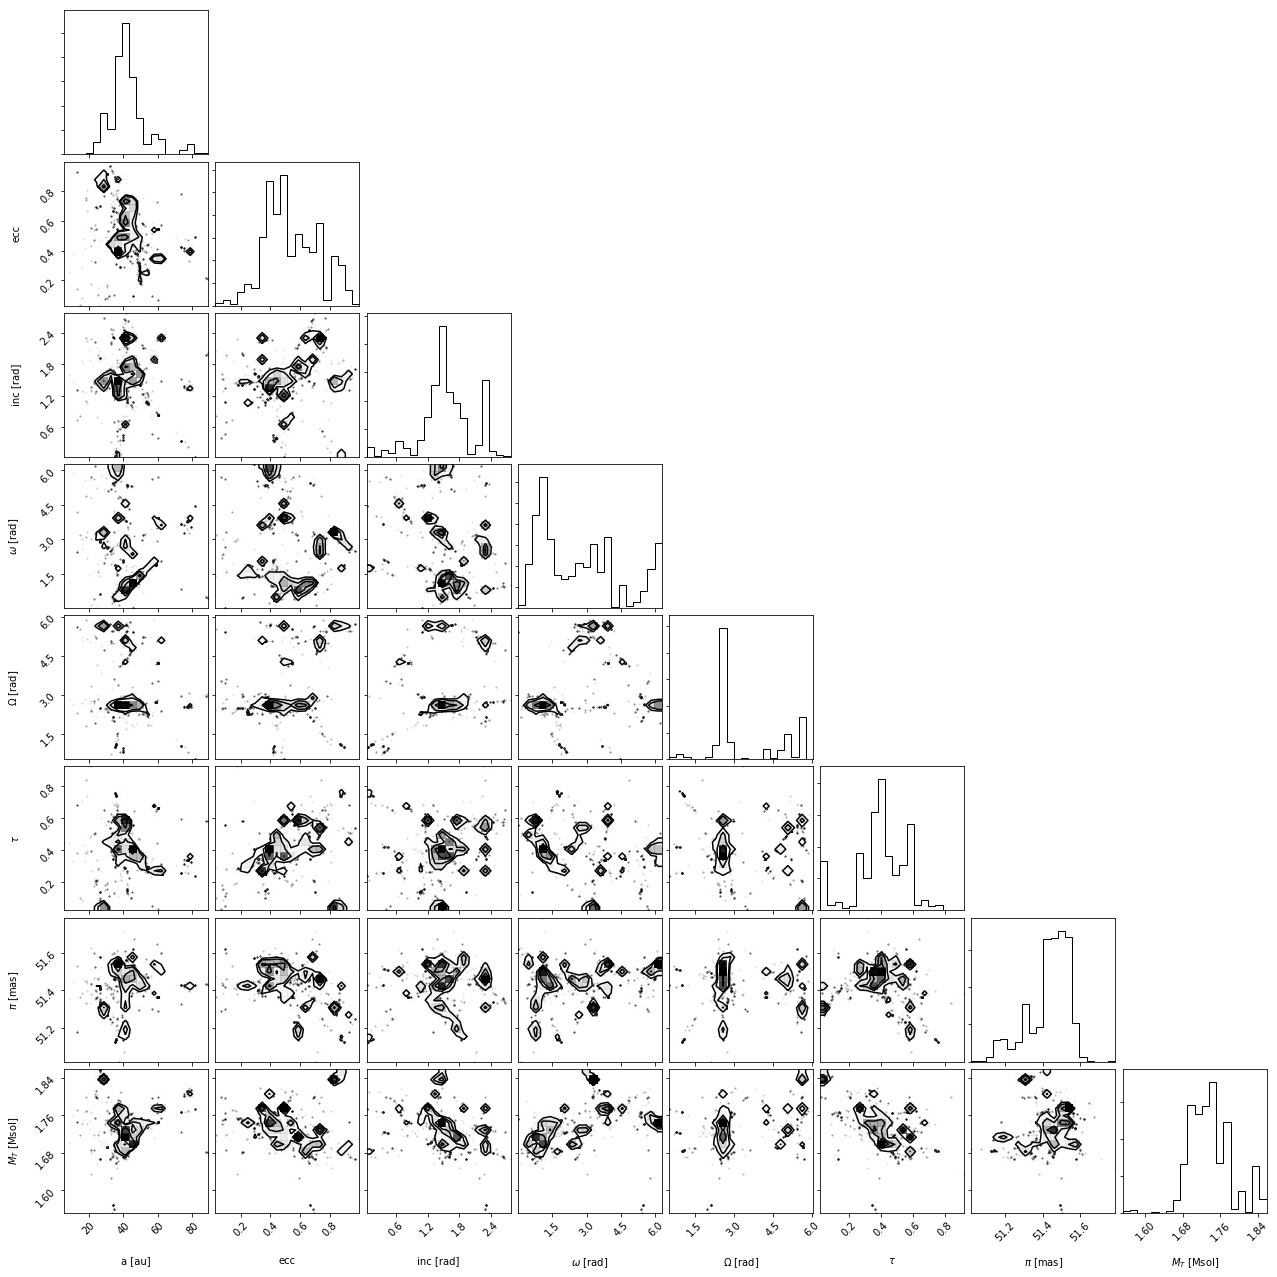

In [4]:
corner_plot_fig = my_driver.sampler.results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('my_corner_plot.png') # This is matplotlib.figure.Figure.savefig()

Next, we can plot a visualization of a selection of orbits sampled by our sampler. By default, the first epoch
plotted is the year 2000 and 100 sampled orbits are displayed.

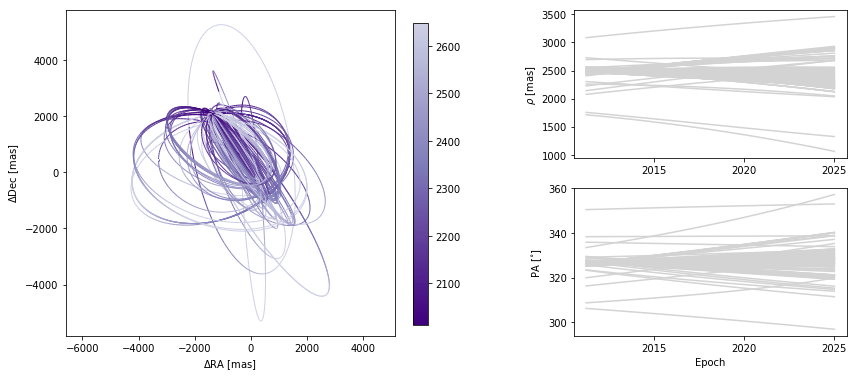

In [5]:
orbit_plot_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=my_driver.system.data_table['epoch'][0] # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig('my_orbit_plot.png') # This is matplotlib.figure.Figure.savefig()

For more advanced plotting options and suggestions on what to do with the returned matplotlib Figure objects,
see the dedicated Plotting tutorial.


## Saving and Loading Results

We will save the results in the HDF5 format. It will save two datasets: `'post'` which will contain the posterior
(the chains of the lowest temperature walkers) and `'lnlike'` which has the corresponding probabilities. In addition,
it saves `'sampler_name'` as an attribute of the HDF5 root group.

In [10]:
hdf5_filename='my_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename): 
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

Saving sampler results is a good idea when we want to analyze the results in a different script or when we want to save the output of a long MCMC run to avoid having to re-run it in the future. We can then load the saved results into a new blank results object.

In [11]:
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename)

Instead of loading results into an orbitize.results.Results object, we can also directly access the saved data using
the `'h5py'` python module.

In [12]:
import h5py
filename = 'my_posterior.hdf5'
hf = h5py.File(filename,'r') # Opens file for reading
# Load up each dataset from hdf5 file
sampler_name = np.str(hf.attrs['sampler_name'])
post = np.array(hf.get('post'))
lnlike = np.array(hf.get('lnlike'))
hf.close() # Don't forget to close the file

Although HDF5 is the recommended and default way to save results, we can also save and load as a Binary FITS table.

In [14]:
fits_filename='my_posterior.fits'
import os
# To avoid weird behaviours, delete saved file if it already exists from previous run of this notebook
if os.path.isfile(fits_filename): 
    os.remove(fits_filename)
# Saving results object
my_driver.sampler.results.save_results(fits_filename, format='fits')

# Loading results object
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(fits_filename, format='fits')

And, if we want to directly access the saved data, we should know that the data are saved as a Binary FITS Table
to the **first extension** HDU with information saved in the header and data attributes as below.

In [15]:
from astropy.io import fits
hdu_list = fits.open(fits_filename) # Opens file as HDUList object
table_hdu = hdu_list[1] # Table data is in first extension
# Get sampler_name from header
sampler_name = table_hdu.header['SAMPNAME']
# Get post and lnlike arrays from column names
post = table_hdu.data.field('post')
lnlike = table_hdu.data.field('lnlike')
# Closes HDUList object
hdu_list.close()